### Part 5. Dogs classification (2+ points)
__Disclaimer__: Это опциональная часть задания. Здесь придется экспериментировать, подбирать оптимальную структуру сети для решения задачи и активно искать подскзаки в сети.

Предлагаем вам решить задачу классификации пород собак. Вы можете обучить сеть с нуля или же воспользоваться методом fine-tuning'а. Полезная ссылка на [предобученные модели](https://pytorch.org/docs/stable/torchvision/models.html).

Данные можно скачать [отсюда](https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip?dl=0). Датасет представлен 50 классами пород собак, которые можно найти в папке train в соответствующих директориях. При сдаче данной части задания вместе с ноутбуком необходимо отправить .csv-файл с предсказаниями классов тестовой выборки в формате: <имя изображения>,<метка класса> по одному объекту на строку. Ниже приведите код ваших экспериментов и короткий вывод по их результатам.

Будут оцениваться качество классификации (accuracy) на тестовой выборке (2 балла) и проведенные эксперименты (1 балл).
Разбалловка следующая:
* $>=$93% - 2 points
* $>=$84% - 1.5 points
* $>=$70% - 0.75 points

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
! wget  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
! unzip -qq data.zip -d data

--2023-10-02 13:26:58--  https://www.dropbox.com/s/vgqpz2f1lolxmlv/data.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/vgqpz2f1lolxmlv/data.zip [following]
--2023-10-02 13:26:58--  https://www.dropbox.com/s/raw/vgqpz2f1lolxmlv/data.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucf874ae519c173f59407d673b79.dl.dropboxusercontent.com/cd/0/inline/CE2GJ9GCLt5giuNa6tBg0DqPIz9hzH6SoZ1M2wjaiImIH8ntaawdjm2GqT6A-sFGwPfOB9S65O_7aPEYTipIN5Crh3gFZNsx96Vlj8XiZUP7adDwxNYsyb1IXfz7CoGpyFE/file# [following]
--2023-10-02 13:26:58--  https://ucf874ae519c173f59407d673b79.dl.dropboxusercontent.com/cd/0/inline/CE2GJ9GCLt5giuNa6tBg0DqPIz9hzH6SoZ1M2wjaiImIH8ntaawdjm2GqT6A-sFGwPfOB9S65O_7aPEYTipIN5Crh3gFZNsx96Vlj8XiZUP7adDwxNYsyb1IXfz7CoGpyFE/fil

In [2]:
%pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.3 MB/s eta 0:00:00


In [3]:
import torch
from torchvision import transforms
from torchsummary import summary
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics import Accuracy

from matplotlib import pyplot as plt
import numpy as np
import time
from collections import defaultdict
from tqdm.auto import tqdm

import os
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
# DATA_PATH = os.path.join('drive', 'MyDrive', 'Datasets', 'Dog breeds', 'data')
DATA_PATH = os.path.join('data', 'data')
# CHECKPOINT_PATH = os.path.join('drive', 'MyDrive', 'models', 'ml_course')
NUM_WORKERS = 2
SIZE_H = SIZE_W = 128
NUM_CLASSES = 50
EPOCH_NUM = 30
BATCH_SIZE = 128
image_mean = [0.485, 0.456, 0.406]
image_std  = [0.229, 0.224, 0.225]

In [5]:
transformer = transforms.Compose([
    transforms.Resize((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])
transformer_augmented = transforms.Compose([
    transforms.RandomRotation((-15, 15)),
    #transforms.RandomCrop(96, 96),
    transforms.RandomEqualize(p=0.5),
    transforms.RandomAutocontrast(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((SIZE_H, SIZE_W)),
    transforms.ToTensor(),
    transforms.Normalize(image_mean, image_std)
])

In [6]:
dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
dataset_aug = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer_augmented)

In [7]:
train_dataset_or, val_dataset_or = torch.utils.data.random_split(dataset=dataset, lengths=(0.75, 0.25))
train_dataset_aug, val_dataset_aug = torch.utils.data.random_split(dataset=dataset_aug, lengths=(0.75, 0.25))
train_dataset = train_dataset_or + train_dataset_aug
val_dataset = val_dataset_or + val_dataset_aug

In [ ]:
# dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'train'), transform=transformer)
# train_dataset, val_dataset = torch.utils.data.random_split(dataset=dataset, lengths=(0.75, 0.25))

In [8]:
label = dict()

for i in val_dataset:
    if i[1] in label:
        label[i[1]] += 1
    else:
        label[i[1]] = 1
label


{30: 82,
 45: 78,
 43: 70,
 17: 62,
 34: 79,
 1: 58,
 2: 65,
 39: 64,
 12: 71,
 10: 71,
 18: 125,
 25: 65,
 5: 61,
 36: 61,
 21: 68,
 13: 68,
 28: 59,
 23: 68,
 26: 62,
 9: 63,
 6: 82,
 11: 72,
 37: 68,
 8: 85,
 49: 57,
 22: 60,
 15: 59,
 41: 65,
 35: 87,
 44: 67,
 48: 92,
 24: 72,
 46: 75,
 27: 71,
 33: 81,
 38: 71,
 32: 85,
 29: 95,
 20: 48,
 4: 58,
 16: 77,
 47: 66,
 31: 102,
 0: 91,
 3: 72,
 7: 64,
 19: 74,
 40: 62,
 14: 62,
 42: 62}

In [9]:
len(label)

50

In [10]:
len(train_dataset), len(val_dataset)

(10750, 3582)

In [11]:
# test_dataset = torchvision.datasets.ImageFolder(os.path.join(DATA_PATH, 'test'), transform=transformer)
# len(test_dataset)

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           num_workers=NUM_WORKERS)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS)

# test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
#                                          batch_size=BATCH_SIZE,
#                                          num_workers=NUM_WORKERS)

In [13]:
def plot_from_batch_generator(batch_gen):
    data_batch, label_batch = next(iter(batch_gen))
    grid_size = (3, 3)
    f, axarr = plt.subplots(*grid_size)
    f.set_size_inches(15,10)
    for i in range(grid_size[0] * grid_size[1]):

        # read images from batch to numpy.ndarray and change axes order [H, W, C] -> [H, W, C]
        batch_image_ndarray = np.transpose(data_batch[i].numpy(), [1, 2, 0])

        # inverse normalization for image data values back to [0,1] and clipping the values for correct pyplot.imshow()
        src = np.clip(image_std * batch_image_ndarray + image_mean, 0, 1)

        # display batch samples with labels
        sample_title = 'Label = %d' % (label_batch[i])
        axarr[i // grid_size[0], i % grid_size[0]].imshow(src)
        axarr[i // grid_size[0], i % grid_size[0]].set_title(sample_title)
    pass

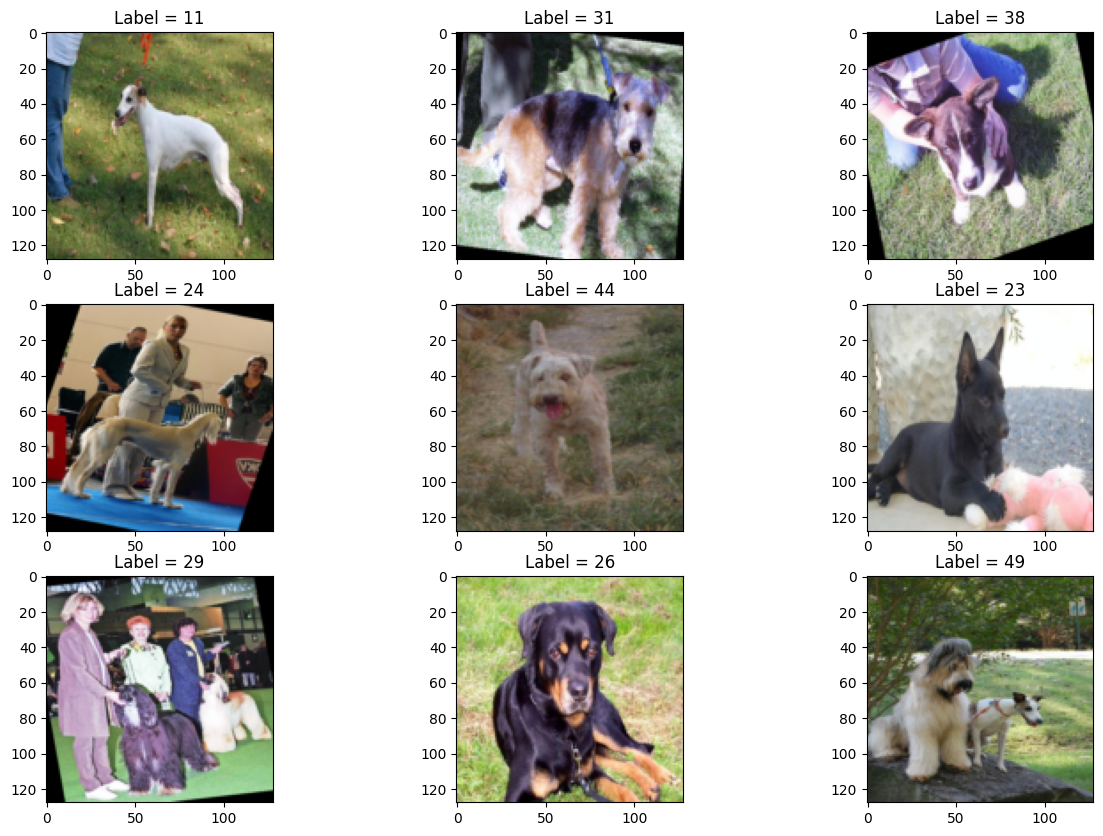

In [14]:
plot_from_batch_generator(train_loader)

In [ ]:
# from IPython.display import clear_output

# class Runner():
#     def __init__(self, model, opt, device, criterion, metric, checkpoint_path=None):
#         self.model = model
#         self.opt = opt
#         self.device = device
#         self.criterion = criterion
#         self.metric = metric
#         self.checkpoint_path = checkpoint_path
#         self.epoch = 0
#         self.train_phase = True
#         self.logits = None
#         self._top_val_score = -1
#         self.log_dict = {
#             "train_loss": [],
#             "val_loss": [],
#             "train_score": [],
#             "val_score": []}

#     def forward(self, X_batch):
#         logits = self.model(X_batch)
#         return logits

#     def _run_batch(self, batch):
#         X_batch, _ = batch
#         X_batch = X_batch.to(self.device)
#         self.logits = self.forward(X_batch)

#     def _run_criterion(self, batch):
#         _, y_batch = batch
#         y_batch = y_batch.to(self.device)
#         loss = self.criterion(self.logits, y_batch)
#         y_pred = torch.max(F.softmax(self.logits, dim=1), dim=1)[1]
#         score = self.metric(y_pred, y_batch)
#         return loss, score

#     def _run_epoch(self, loader, output_log=True):
#         ep_loss = []
#         ep_score = []
#         _phase_description = 'Training' if self.train_phase else 'Evaluation'
#         for batch in tqdm(loader, desc=_phase_description, leave=False):
#             self._run_batch(batch)

#             with torch.set_grad_enabled(self.train_phase):
#                 loss, score = self._run_criterion(batch)

#             if self.train_phase:
#                 loss.backward()
#                 self.opt.step()
#                 self.opt.zero_grad()

#             ep_loss.append(loss.item())
#             ep_score.append(score.item())

#         if self.train_phase:
#             self.log_dict['train_loss'].append(np.mean(ep_loss))
#             self.log_dict['train_score'].append(np.mean(ep_score))
#         else:
#             self.log_dict['val_loss'].append(np.mean(ep_loss))
#             self.log_dict['val_score'].append(np.mean(ep_score))

#         if output_log:
#             self.output_log()

#     def save_checkpoint(self):
#         val_score = self.log_dict['val_score'][-1]
#         if val_score > self._top_val_score and self.checkpoint_path is not None:
#             self._top_val_score = val_score
#             if val_score > 0.6:
#                 torch.save(self.model, open(self.checkpoint_path, 'wb'))

#     def load_checkpoint(self):
#         if self.checkpoint_path is not None:
#             self.model = torch.load(self.checkpoint_path)

#     def output_log(self):
#         if self.visualize:
#             clear_output()

#         phase = 'Training' if self.train_phase else 'Evaluation'

#         print(f'{phase}: ', end='')
#         if self.train_phase:
#             print(f'Train loss: {self.log_dict["train_loss"][-1]}; Train score: {self.log_dict["train_score"][-1]}')
#         else:
#             print(f'Val loss: {self.log_dict["val_loss"][-1]}; Val score: {self.log_dict["val_score"][-1]}')
#             #self.save_checkpoint()

#         if self.visualize:
#             fig, axes = plt.subplots(1, 2, figsize=(15, 5))

#             axes[0].set_title('Loss')
#             axes[0].plot(self.log_dict["train_loss"], label='train')
#             axes[0].plot(self.log_dict["val_loss"], label='validate')
#             axes[0].legend()

#             axes[1].set_title('Accuracy')
#             axes[1].plot(self.log_dict["train_score"], label='train')
#             axes[1].plot(self.log_dict["val_score"], label='validate')
#             axes[1].legend()

#             plt.show()


#     def train(self, train_loader, val_loader, n_epochs, visualize=True, model=None, opt=None, criterion=None, metric=None):
#         self.visualize = visualize
#         self.opt = (opt or self.opt)
#         self.model = (model or self.model)
#         self.criterion = (criterion or self.criterion)
#         self.metric = (metric or self.metric)
#         self.train_phase = True
#         self.model.train(self.train_phase)

#         for _epoch in range(n_epochs):
#             self.train_phase = True
#             start_time = time.time()
#             self.epoch += 1
#             print(f"epoch {self.epoch:3d}/{n_epochs:3d} started")

#             self._run_epoch(train_loader)

#             print(f"epoch {self.epoch:3d}/{n_epochs:3d} took {time.time() - start_time:.2f}s")

#             self.train_phase = False
#             self.validate(val_loader)
#             self.save_checkpoint()

#     @torch.no_grad()
#     def validate(self, loader):
#         self.train_phase = False
#         self.model.train(self.train_phase)
#         self._run_epoch(loader)

#     @torch.no_grad()
#     def predict(self, X=None, loader=None):
#         self.load_checkpoint()
#         self.train_phase = False
#         self.model.train(self.train_phase)
#         if loader:
#             pred_label = []
#             for X_batch in tqdm(loader, desc='Test', leave=False):
#                 X_batch = X_batch.to(self.device)
#                 self.logits = self.forward(X_batch)
#                 y_pred = torch.max(F.softmax(self.logits, dim=1), dim=1)[1]
#                 pred_label.append(y_pred.item())
#         if X:
#             self.logits = self.forward(X)
#             pred_label = torch.max(F.softmax(self.logits, dim=1), dim=1)[1]

#         return pred_label


In [15]:
def train_eval_model(model, loss_func, opt, metric, train_loader,
                     val_loader, n_epochs, checkpoint_path=None):
    train_loss = []
    test_loss = []
    train_metric = []
    test_metric = []
    best_test_metric = -1


    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_test_loss = []
        ep_train_metric = []
        ep_test_metric = []

        model.train(True)

        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            loss = loss_func(logits, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()

            ep_train_loss.append(loss.item())
            y_pred = torch.max(F.softmax(logits, dim=1), dim=1)[1]
            ep_train_metric.append(metric(y_pred, y_batch).item())

        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)

                logits = model(X_batch)
                loss = loss_func(logits, y_batch)
                ep_test_loss.append(loss.item())

                y_pred = torch.max(F.softmax(logits, dim=1), dim=1)[1]
                ep_test_metric.append(metric(y_pred, y_batch).item())

                if ep_test_metric[-1] > best_test_metric and checkpoint_path is not None:
                    best_test_metric = ep_test_metric[-1]
                    torch.save(model, open(checkpoint_path, 'wb'))

        print(f'Epoch: {epoch+1}')

        train_loss.append(np.mean(ep_train_loss))
        test_loss.append(np.mean(ep_test_loss))
        train_metric.append(np.mean(ep_train_metric))
        test_metric.append(np.mean(ep_test_metric))

        print(f'tarining loss: {train_loss[-1]:.6f}')
        print(f'test loss: {test_loss[-1]:.6f}')
        print(f'train metric: {train_metric[-1]:.3f}')
        print(f'test metric: {test_metric[-1]:.3f}')

    return train_loss, test_loss, train_metric, test_metric


def plot_train_process(train_loss, test_loss, train_metric, test_metric):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    axes[0].set_title('Loss')
    axes[0].plot(train_loss, label='train')
    axes[0].plot(test_loss, label='test')
    axes[0].legend()

    axes[1].set_title('Accuracy')
    axes[1].plot(train_metric, label='train')
    axes[1].plot(test_metric, label='test')
    axes[1].legend()

In [ ]:
#Base line model

def conv_block_3x3(in_channels, out_channels, stride=1):
    return nn.Sequential(
        nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.3),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.5),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Dropout(p=0.5),
        nn.Conv2d(in_channels=128, out_channels=out_channels, kernel_size=3),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )

class SimpleCNN(torch.nn.Module):
    def __init__(self):
        super(self.__class__, self).__init__()

        self.model = nn.Sequential(
            conv_block_3x3(3, 256, 1),
            nn.AdaptiveMaxPool2d(1),
            nn.Flatten())
        self.dropout0_5 = nn.Dropout(p=0.5)
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU())

        self.pred = nn.Sequential(
            nn.Linear(128, NUM_CLASSES, bias=False))

    def forward(self, x):
        x = self.model(x)
        x = self.dropout0_5(x)
        x = self.fc(x)
        x = self.dropout0_5(x)
        x = self.pred(x)
        return x


In [ ]:
base_line_cnn = SimpleCNN()
summary(base_line_cnn, (3, SIZE_H, SIZE_W), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 126, 126]             896
       BatchNorm2d-2         [-1, 32, 126, 126]              64
              ReLU-3         [-1, 32, 126, 126]               0
         MaxPool2d-4           [-1, 32, 63, 63]               0
           Dropout-5           [-1, 32, 63, 63]               0
            Conv2d-6           [-1, 64, 61, 61]          18,496
       BatchNorm2d-7           [-1, 64, 61, 61]             128
              ReLU-8           [-1, 64, 61, 61]               0
         MaxPool2d-9           [-1, 64, 30, 30]               0
          Dropout-10           [-1, 64, 30, 30]               0
           Conv2d-11          [-1, 128, 28, 28]          73,856
      BatchNorm2d-12          [-1, 128, 28, 28]             256
             ReLU-13          [-1, 128, 28, 28]               0
        MaxPool2d-14          [-1, 128,

Epoch: 1
tarining loss: 3.996956
test loss: 3.955452
train metric: 0.028
test metric: 0.032
Epoch: 2
tarining loss: 3.915237
test loss: 4.047322
train metric: 0.036
test metric: 0.018
Epoch: 3
tarining loss: 3.860077
test loss: 4.050873
train metric: 0.045
test metric: 0.018
Epoch: 4
tarining loss: 3.809535
test loss: 4.174143
train metric: 0.052
test metric: 0.019
Epoch: 5
tarining loss: 3.756344
test loss: 3.905335
train metric: 0.061
test metric: 0.029
Epoch: 6
tarining loss: 3.696352
test loss: 4.036195
train metric: 0.070
test metric: 0.025
Epoch: 7
tarining loss: 3.673282
test loss: 3.839645
train metric: 0.076
test metric: 0.051
Epoch: 8
tarining loss: 3.630075
test loss: 3.697005
train metric: 0.080
test metric: 0.063
Epoch: 9
tarining loss: 3.595636
test loss: 3.604572
train metric: 0.085
test metric: 0.077
Epoch: 10
tarining loss: 3.561800
test loss: 3.702992
train metric: 0.091
test metric: 0.059
Epoch: 11
tarining loss: 3.525577
test loss: 3.569595
train metric: 0.094
test 

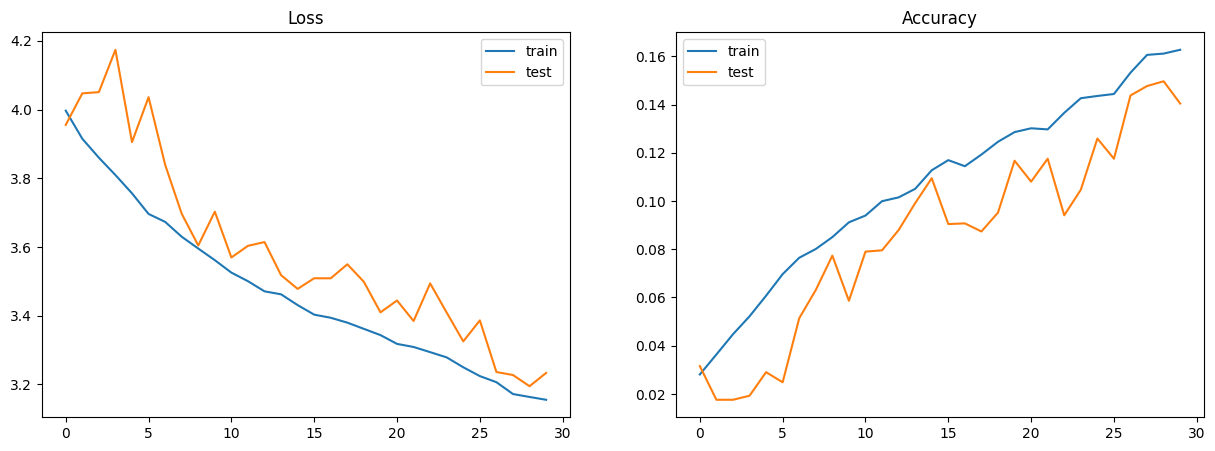

In [ ]:
base_line_cnn = base_line_cnn.to(device)
opt = torch.optim.Adam(base_line_cnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
checkpoint_path = r'base_line_cnn_model.ckpt'

train_loss, test_loss, train_metric, test_metric = train_eval_model(model=base_line_cnn, loss_func=criterion, opt=opt,
                                                                    metric=metric, train_loader=train_loader,
                                                                    val_loader=val_loader, n_epochs=30)
plot_train_process(train_loss, test_loss, train_metric, test_metric)

# runner_base_line = Runner(model=base_line_cnn, opt=opt, device=device,
#                           criterion=criterion, metric=metric,
#                           checkpoint_path=checkpoint_path)

# runner_base_line.train(train_loader=train_loader,
#                        val_loader=val_loader, n_epochs=20)


In [ ]:
model_resnet50 = torchvision.models.resnet50(pretrained=True)

In [ ]:
num_feat = model_resnet50.fc.in_features
num_feat

2048

In [ ]:
for name, p in model_resnet50.named_parameters():
    if not name.startswith('fc') or not name.startswith('layer4.2'):
    # if not name.startswith('fc'):
        p.requires_grad_(False)

In [ ]:
model_resnet50.fc = nn.Sequential(nn.Dropout(p=0.5),
                                  nn.Linear(num_feat, 1024),
                                  nn.BatchNorm1d(1024),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.5),
                                  nn.Linear(1024, 512),
                                  nn.BatchNorm1d(512),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.5),
                                  nn.Linear(512, NUM_CLASSES))
model_resnet50 = model_resnet50.to(device)

In [ ]:
summary(model_resnet50, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Epoch: 1
tarining loss: 3.168898
test loss: 2.214634
train metric: 0.251
test metric: 0.568
Epoch: 2
tarining loss: 2.105540
test loss: 1.660025
train metric: 0.506
test metric: 0.630
Epoch: 3
tarining loss: 1.724192
test loss: 1.377627
train metric: 0.567
test metric: 0.655
Epoch: 4
tarining loss: 1.534040
test loss: 1.264274
train metric: 0.596
test metric: 0.673
Epoch: 5
tarining loss: 1.439042
test loss: 1.187521
train metric: 0.606
test metric: 0.676
Epoch: 6
tarining loss: 1.375670
test loss: 1.147952
train metric: 0.623
test metric: 0.688
Epoch: 7
tarining loss: 1.305941
test loss: 1.108899
train metric: 0.636
test metric: 0.696
Epoch: 8
tarining loss: 1.280440
test loss: 1.075825
train metric: 0.644
test metric: 0.706
Epoch: 9
tarining loss: 1.245045
test loss: 1.077538
train metric: 0.656
test metric: 0.704
Epoch: 10
tarining loss: 1.202601
test loss: 1.062644
train metric: 0.662
test metric: 0.708
Epoch: 11
tarining loss: 1.184247
test loss: 1.025199
train metric: 0.659
test 

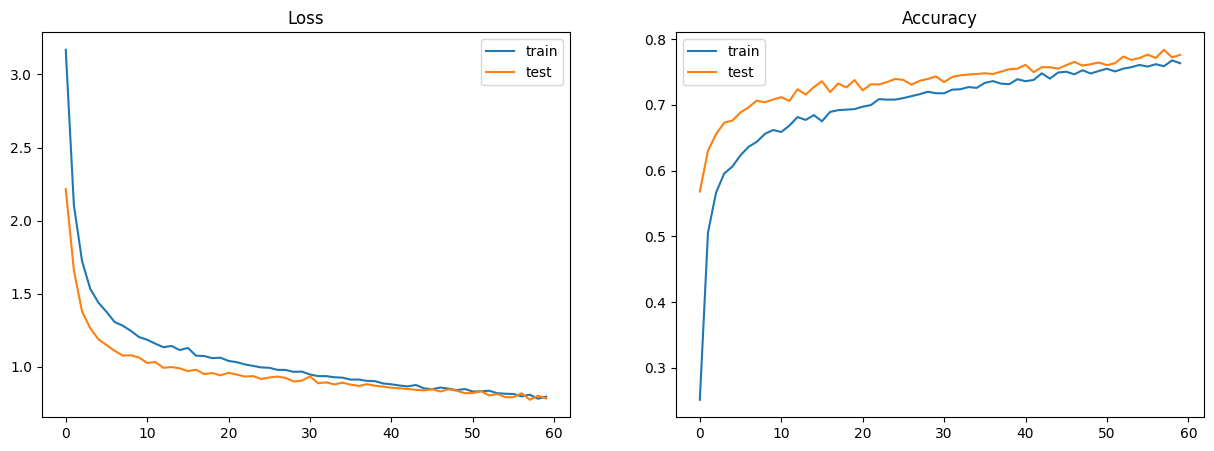

In [ ]:
opt = torch.optim.Adam(model_resnet50.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss()
metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
checkpoint_path = 'model_resnet_18_finetune.ckpt'

train_loss, test_loss, train_metric, test_metric = train_eval_model(model=model_resnet50, loss_func=criterion, opt=opt,
                                                                    metric=metric, train_loader=train_loader,
                                                                    val_loader=val_loader, n_epochs=60, checkpoint_path=checkpoint_path)
plot_train_process(train_loss, test_loss, train_metric, test_metric)


# runner_base_line = Runner(model=model_resnet50, opt=opt, device=device,
#                           criterion=criterion, metric=metric,
#                           checkpoint_path=checkpoint_path)

# runner_base_line.train(train_loader=train_loader,
#                        val_loader=val_loader, n_epochs=20)

In [22]:
model_resnet50v1 = torchvision.models.resnet50(pretrained=True)

In [23]:
num_feat = model_resnet50v1.fc.in_features
num_feat

2048

In [24]:
for name, p in model_resnet50v1.named_parameters():
    if not name.startswith('fc') or not name.startswith('layer4'):
    # if not name.startswith('fc'):
        p.requires_grad_(False)

In [25]:
model_resnet50v1.fc = nn.Sequential(nn.Dropout(p=0.5),
                                  nn.Linear(num_feat, 1024),
                                  nn.BatchNorm1d(1024),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.5),
                                  nn.Linear(1024, 512),
                                  nn.BatchNorm1d(512),
                                  nn.ReLU(),
                                  nn.Dropout(p=0.5),
                                  nn.Linear(512, NUM_CLASSES))
model_resnet50v1 = model_resnet50v1.to(device)

In [26]:
summary(model_resnet50v1, (3, SIZE_H, SIZE_W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

Epoch: 1
tarining loss: 2.380625
test loss: 1.404154
train metric: 0.413
test metric: 0.653
Epoch: 2
tarining loss: 1.545619
test loss: 1.167313
train metric: 0.571
test metric: 0.678
Epoch: 3
tarining loss: 1.405772
test loss: 1.096889
train metric: 0.604
test metric: 0.695
Epoch: 4
tarining loss: 1.339898
test loss: 1.049555
train metric: 0.624
test metric: 0.702
Epoch: 5
tarining loss: 1.303828
test loss: 1.031081
train metric: 0.625
test metric: 0.710
Epoch: 6
tarining loss: 1.258179
test loss: 1.006462
train metric: 0.636
test metric: 0.720
Epoch: 7
tarining loss: 1.214866
test loss: 0.993932
train metric: 0.652
test metric: 0.715
Epoch: 8
tarining loss: 1.206074
test loss: 0.970653
train metric: 0.656
test metric: 0.722
Epoch: 9
tarining loss: 1.159266
test loss: 0.962731
train metric: 0.663
test metric: 0.725
Epoch: 10
tarining loss: 1.133587
test loss: 0.958363
train metric: 0.668
test metric: 0.723
Epoch: 11
tarining loss: 1.129976
test loss: 0.933919
train metric: 0.667
test 

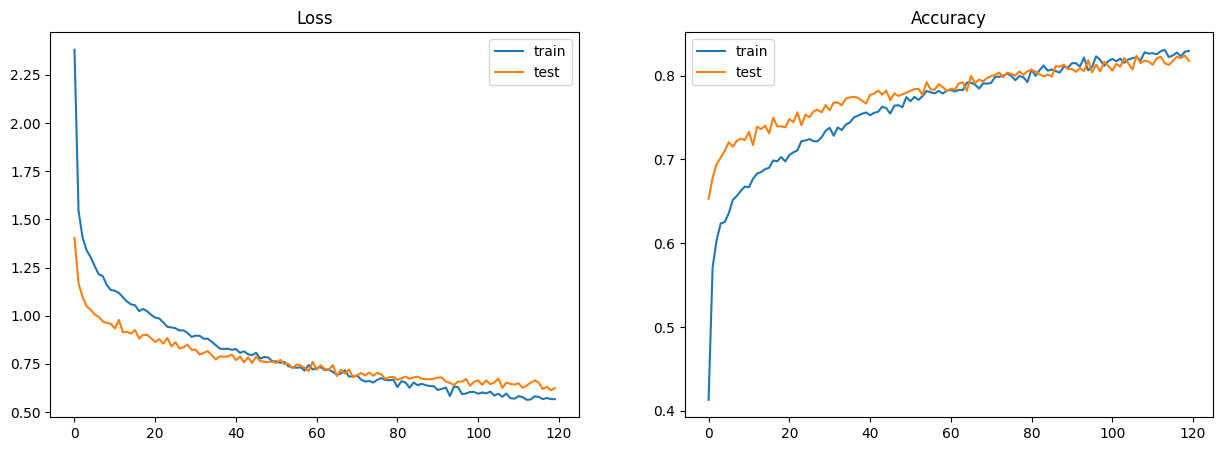

In [27]:
opt = torch.optim.Adam(model_resnet50v1.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()
metric = Accuracy(task="multiclass", num_classes=NUM_CLASSES).to(device)
checkpoint_path = 'model_resnet_50_v1_finetune.ckpt'

train_loss, test_loss, train_metric, test_metric = train_eval_model(model=model_resnet50v1, loss_func=criterion, opt=opt,
                                                                    metric=metric, train_loader=train_loader,
                                                                    val_loader=val_loader, n_epochs=120, checkpoint_path=checkpoint_path)
plot_train_process(train_loss, test_loss, train_metric, test_metric)